# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

In [2]:
tf.__version__

'2.5.0'

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load KNIME's Model

In [5]:
knime_model = tf.keras.models.load_model(os.path.join("models", "KNIME_LSTM_new.h5"))

In [6]:
knime_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 1)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


# Get the Data

This is referring to the Demand Prediction example in the KNIME's textbook in Chapter 6.

In [7]:
DATA_PATH = "data"

In [8]:
# unpreprocessed full data
df = pd.read_csv(os.path.join(DATA_PATH, "clustered_hourly_values_all_w_missing_times.csv"))
df.head()

,row ID,cluster_11,cluster_28,cluster_24,cluster_1,cluster_12,cluster_2,cluster_23,cluster_26,cluster_21,...,cluster_14,cluster_20,cluster_4,cluster_8,cluster_7,cluster_22,cluster_25,cluster_9,cluster_15,cluster_3
0,2009-07-15_00,0.198786,18.358000,0.777450,2.488265,9.594552,0.462515,0.391711,3.254085,0.357386,...,0.897384,0.598728,0.920695,0.875265,0.845983,0.658726,1.382476,1.037702,1.090514,0.947526
1,2009-07-15_01,0.171071,16.028357,0.591275,2.747633,7.681776,0.260338,0.398816,3.197561,0.364500,...,0.612620,0.395499,0.561120,0.650493,0.587325,0.438029,0.972665,0.730954,0.781937,0.580975
2,2009-07-15_02,0.162000,15.065393,0.483900,2.497571,6.972241,0.296500,0.396171,3.038390,0.361659,...,0.490683,0.324087,0.426242,0.522865,0.499978,0.346501,0.696608,0.518665,0.595129,0.452213
3,2009-07-15_03,0.189571,15.304214,0.353325,2.404000,6.804086,0.247176,0.399645,3.029756,0.349489,...,0.457262,0.303519,0.376581,0.469952,0.462120,0.334346,0.563122,0.423768,0.531196,0.416438
4,2009-07-15_04,0.320929,15.284107,0.378625,2.156265,6.595086,0.252132,0.411039,3.005634,0.347057,...,0.447911,0.283072,0.359359,0.485992,0.463902,0.314235,0.535823,0.382569,0.502776,0.398079


In [9]:
# the example only uses cluster 26
df = df[['row ID', 'cluster_26']]
df.head()

,row ID,cluster_26
0,2009-07-15_00,3.254085
1,2009-07-15_01,3.197561
2,2009-07-15_02,3.038390
3,2009-07-15_03,3.029756
4,2009-07-15_04,3.005634


In [10]:
# preprocessed but have not gone through Column Aggregator nodes yet
train_df = pd.read_csv(os.path.join(DATA_PATH, "DemandPrediction_TrainingSet.csv"))
train_df.head()

,cluster_26,row ID,cluster_26(-1),cluster_26(-2),cluster_26(-3),cluster_26(-4),cluster_26(-5),cluster_26(-6),cluster_26(-7),cluster_26(-8),...,cluster_26(-191),cluster_26(-192),cluster_26(-193),cluster_26(-194),cluster_26(-195),cluster_26(-196),cluster_26(-197),cluster_26(-198),cluster_26(-199),cluster_26(-200)
0,6.478671,2009-07-23T08:00,4.169061,2.965000,3.074915,3.073512,3.200780,3.210793,3.272939,3.379171,...,11.495024,6.899854,4.024280,2.881841,2.943738,3.005634,3.029756,3.038390,3.197561,3.254085
1,11.557817,2009-07-23T09:00,6.478671,4.169061,2.965000,3.074915,3.073512,3.200780,3.210793,3.272939,...,14.180427,11.495024,6.899854,4.024280,2.881841,2.943738,3.005634,3.029756,3.038390,3.197561
2,13.698671,2009-07-23T10:00,11.557817,6.478671,4.169061,2.965000,3.074915,3.073512,3.200780,3.210793,...,15.321268,14.180427,11.495024,6.899854,4.024280,2.881841,2.943738,3.005634,3.029756,3.038390
3,14.649000,2009-07-23T11:00,13.698671,11.557817,6.478671,4.169061,2.965000,3.074915,3.073512,3.200780,...,15.046780,15.321268,14.180427,11.495024,6.899854,4.024280,2.881841,2.943738,3.005634,3.029756
4,14.466024,2009-07-23T12:00,14.649000,13.698671,11.557817,6.478671,4.169061,2.965000,3.074915,3.073512,...,14.585280,15.046780,15.321268,14.180427,11.495024,6.899854,4.024280,2.881841,2.943738,3.005634


From the output above, you can see that the target value is the first value of the next sequence, this means that we are predicting the next timestep given the previous 200 timesteps.

In [11]:
# cluster_26 column is the target, row ID is the datetime in hour, while the rest are the previous 200 timesteps
print(train_df.columns.values)

['cluster_26' 'row ID' 'cluster_26(-1)' 'cluster_26(-2)' 'cluster_26(-3)'
 'cluster_26(-4)' 'cluster_26(-5)' 'cluster_26(-6)' 'cluster_26(-7)'
 'cluster_26(-8)' 'cluster_26(-9)' 'cluster_26(-10)' 'cluster_26(-11)'
 'cluster_26(-12)' 'cluster_26(-13)' 'cluster_26(-14)' 'cluster_26(-15)'
 'cluster_26(-16)' 'cluster_26(-17)' 'cluster_26(-18)' 'cluster_26(-19)'
 'cluster_26(-20)' 'cluster_26(-21)' 'cluster_26(-22)' 'cluster_26(-23)'
 'cluster_26(-24)' 'cluster_26(-25)' 'cluster_26(-26)' 'cluster_26(-27)'
 'cluster_26(-28)' 'cluster_26(-29)' 'cluster_26(-30)' 'cluster_26(-31)'
 'cluster_26(-32)' 'cluster_26(-33)' 'cluster_26(-34)' 'cluster_26(-35)'
 'cluster_26(-36)' 'cluster_26(-37)' 'cluster_26(-38)' 'cluster_26(-39)'
 'cluster_26(-40)' 'cluster_26(-41)' 'cluster_26(-42)' 'cluster_26(-43)'
 'cluster_26(-44)' 'cluster_26(-45)' 'cluster_26(-46)' 'cluster_26(-47)'
 'cluster_26(-48)' 'cluster_26(-49)' 'cluster_26(-50)' 'cluster_26(-51)'
 'cluster_26(-52)' 'cluster_26(-53)' 'cluster_26(-54)' '

In [12]:
train_df.dtypes

cluster_26          float64
row ID               object
cluster_26(-1)      float64
cluster_26(-2)      float64
cluster_26(-3)      float64
                     ...   
cluster_26(-196)    float64
cluster_26(-197)    float64
cluster_26(-198)    float64
cluster_26(-199)    float64
cluster_26(-200)    float64
Length: 202, dtype: object

We need to convert the `row ID` column to `datetime` format and set it to our index for visualization later.

In [13]:
train_df['row ID'] = pd.to_datetime(train_df['row ID'])
train_df.set_index('row ID', inplace=True)

In [14]:
# there are 0 missing value
(train_df.isna().sum() == 0).all()

True

In [15]:
test_df = pd.read_csv(os.path.join(DATA_PATH, "DemandPrediction_TestSet.csv"))
test_df

,cluster_26,row ID,cluster_26(-1),cluster_26(-2),cluster_26(-3),cluster_26(-4),cluster_26(-5),cluster_26(-6),cluster_26(-7),cluster_26(-8),...,cluster_26(-191),cluster_26(-192),cluster_26(-193),cluster_26(-194),cluster_26(-195),cluster_26(-196),cluster_26(-197),cluster_26(-198),cluster_26(-199),cluster_26(-200)
0,6.632909,2010-09-24T08:00,4.489470,3.517848,3.517848,3.517848,3.317803,3.395939,3.537621,3.428667,...,11.807091,6.619803,4.122197,3.209076,3.139364,3.219273,3.198455,3.250061,3.297682,3.382652
1,11.321318,2010-09-24T09:00,6.632909,4.489470,3.517848,3.517848,3.517848,3.317803,3.395939,3.537621,...,14.300909,11.807091,6.619803,4.122197,3.209076,3.139364,3.219273,3.198455,3.250061,3.297682
2,14.767955,2010-09-24T10:00,11.321318,6.632909,4.489470,3.517848,3.517848,3.517848,3.317803,3.395939,...,14.954606,14.300909,11.807091,6.619803,4.122197,3.209076,3.139364,3.219273,3.198455,3.250061
3,15.461939,2010-09-24T11:00,14.767955,11.321318,6.632909,4.489470,3.517848,3.517848,3.517848,3.317803,...,15.467773,14.954606,14.300909,11.807091,6.619803,4.122197,3.209076,3.139364,3.219273,3.198455
4,15.106182,2010-09-24T12:00,15.461939,14.767955,11.321318,6.632909,4.489470,3.517848,3.517848,3.517848,...,14.608530,15.467773,14.954606,14.300909,11.807091,6.619803,4.122197,3.209076,3.139364,3.219273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,3.570083,2010-12-31T19:00,4.668550,6.194500,7.382867,7.382867,9.338467,9.670683,10.281083,10.540667,...,5.041089,5.528929,7.993286,12.122107,13.463589,14.678214,16.282696,18.417929,19.790696,20.618286
2364,3.352850,2010-12-31T20:00,3.570083,4.668550,6.194500,7.382867,7.382867,9.338467,9.670683,10.281083,...,5.159125,5.041089,5.528929,7.993286,12.122107,13.463589,14.678214,16.282696,18.417929,19.790696
2365,3.666383,2010-12-31T21:00,3.352850,3.570083,4.668550,6.194500,7.382867,7.382867,9.338467,9.670683,...,5.280482,5.159125,5.041089,5.528929,7.993286,12.122107,13.463589,14.678214,16.282696,18.417929
2366,3.755767,2010-12-31T22:00,3.666383,3.352850,3.570083,4.668550,6.194500,7.382867,7.382867,9.338467,...,5.465661,5.280482,5.159125,5.041089,5.528929,7.993286,12.122107,13.463589,14.678214,16.282696


In [16]:
test_df['row ID'] = pd.to_datetime(test_df['row ID'])
test_df.set_index('row ID', inplace=True)

In [17]:
# there are 0 missing value
(test_df.isna().sum() == 0).all()

True

# Preparing the data

Because the data is in the form of data right before the Column Aggregator node in KNIME, we need to extract the data and convert them into NumPy arrays to feed into Keras model.

In [18]:
X_train_df = train_df.drop(columns=['cluster_26'])

X_train = X_train_df.values
# must reshape into [N, timesteps, 1]
X_train = X_train.reshape(-1, 200, 1)
X_train.shape

(10072, 200, 1)

In [19]:
X_test_df = test_df.drop(columns=['cluster_26'])

X_test = X_test_df.values
# must reshape into [N, timesteps, 1]
X_test = X_test.reshape(-1, 200, 1)
X_test.shape

(2368, 200, 1)

In [20]:
y_train_df = train_df['cluster_26']

y_train = y_train_df.values
y_train.shape

(10072,)

In [21]:
y_test_df = test_df['cluster_26']

y_test = y_test_df.values
y_test.shape

(2368,)

In [22]:
# you need to pass in the data with shape of [N, timesteps, 1] to Keras model
X_train[:1].shape

(1, 200, 1)

In [23]:
# you can test whether the KNIME's model can make inference with it or not
print(f"Predicted\t: {knime_model.predict(X_train[:1])[0]}")
print(f"Actual\t\t: {y_train[0]}")

Predicted	: [7.654013]
Actual		: 6.478670731707316


# Comparing Prediction Results of Loaded Model VS Model in KNIME

In [24]:
# the example only demo on next 600 samples
knime_pred = knime_model.predict(X_test[:600])
knime_pred.shape

(600, 1)

In [25]:
pred_df = y_test_df[:600].to_frame()
pred_df['predictions'] = knime_pred
pred_df

,cluster_26,predictions
row ID,,
2010-09-24 08:00:00,6.632909,7.934097
2010-09-24 09:00:00,11.321318,12.159174
2010-09-24 10:00:00,14.767955,14.144682
2010-09-24 11:00:00,15.461939,14.549006
2010-09-24 12:00:00,15.106182,14.254324
...,...,...
2010-10-19 03:00:00,3.457500,3.389347
2010-10-19 04:00:00,3.426697,3.298022
2010-10-19 05:00:00,3.358455,3.337390


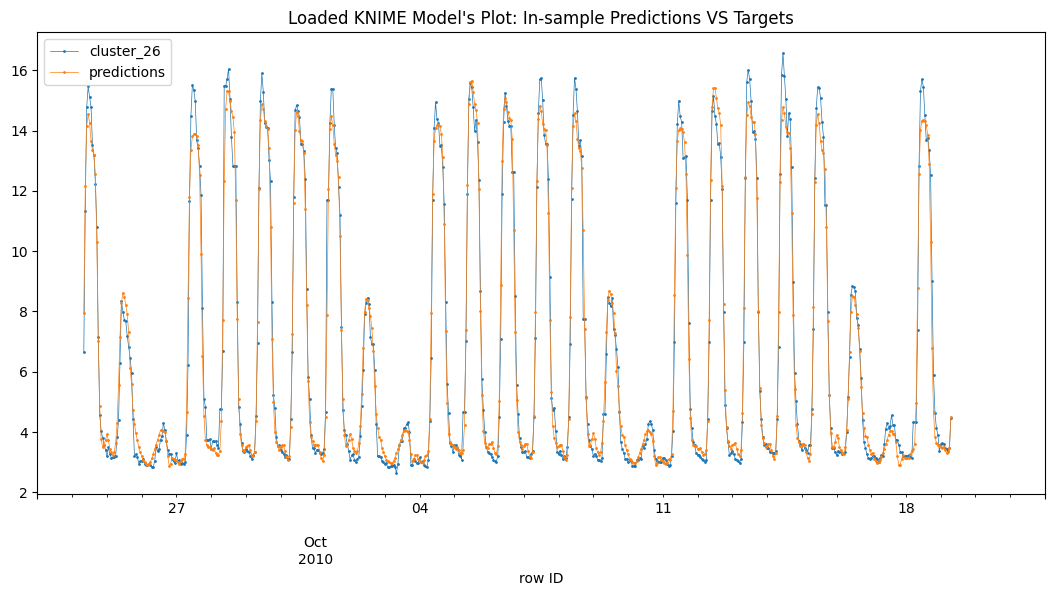

In [26]:
pred_df.plot(
    figsize=(13, 6),
    marker='o',
    markersize=1,
    linewidth=0.5
)
plt.xlim(['2010-09-23', '2010-10-22'])
plt.title("Loaded KNIME Model's Plot: In-sample Predictions VS Targets")
plt.show()

Comparing with model result in KNIME:

![time_series-result_plot.jpeg](results/time_series-result_plot.jpeg)

In [27]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

sample_test = y_test[:600]
r2 = r2_score(sample_test, knime_pred)
mae = mean_absolute_error(sample_test, knime_pred)
mse = mean_squared_error(sample_test, knime_pred)
rmse = mean_squared_error(sample_test, knime_pred, squared=False)
mape = mean_absolute_percentage_error(sample_test, knime_pred)

print(f"R2:\t\t\t\t{r2:.3f}")
print(f"Mean absolute error:\t\t{mae:.3f}")
print(f"Mean squared error:\t\t{mse:.3f}")
print(f"Root mean squared error:\t{rmse:.3f}")
print(f"Mean absolute percentage error:\t{mape:.3f}")

R2:				0.981
Mean absolute error:		0.416
Mean squared error:		0.373
Root mean squared error:	0.611
Mean absolute percentage error:	0.068


![time_series-statiscal_result.jpeg](results/time_series-statiscal_result.jpeg)

The results are exactly the same using the model exported from KNIME.

# Model Building in Python

In [28]:
# check KNIME's keras model see
knime_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 1)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [40]:
from tensorflow.keras import layers

tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=(200, 1)),
    layers.LSTM(100),
    # the book said it used 'relu', which is not possible to output the correct real value
    # hence 'linear' activation function should be used
    layers.Dense(1, activation='linear'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["mse"],
)

In [42]:
history = model.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=50,
)

Epoch 1/50
40/40 [==============================] - 2s 25ms/step - loss: 31.4752 - mse: 31.4752: 0s - loss: 46.1330 - ms - ETA: 0s - loss: 31.7310 - mse: 31.731
Epoch 2/50
40/40 [==============================] - 1s 24ms/step - loss: 22.5220 - mse: 22.5220
Epoch 3/50
40/40 [==============================] - 1s 24ms/step - loss: 14.2890 - mse: 14.2890
Epoch 4/50
40/40 [==============================] - 1s 24ms/step - loss: 8.1155 - mse: 8.1155
Epoch 5/50
40/40 [==============================] - 1s 24ms/step - loss: 5.9783 - mse: 5.9783: 0s - loss: 6.6433 - m
Epoch 6/50
40/40 [==============================] - 1s 23ms/step - loss: 4.4422 - mse: 4.4422
Epoch 7/50
40/40 [==============================] - 1s 23ms/step - loss: 3.7893 - mse: 3.7893: 0s - loss: 3.7893 - mse: 3.789
Epoch 8/50
40/40 [==============================] - 1s 23ms/step - loss: 3.4156 - mse: 3.4156
Epoch 9/50
40/40 [==============================] - 1s 23ms/step - loss: 3.3007 - mse: 3.3007
Epoch 10/50
40/40 [=========

# Evaluation of Python Model VS KNIME Model

In [43]:
# the example only demo on next 600 samples
y_pred = model.predict(X_test[:600])
y_pred.shape

(600, 1)

In [44]:
pred_df = y_test_df[:600].to_frame()
pred_df['predictions'] = y_pred
pred_df

,cluster_26,predictions
row ID,,
2010-09-24 08:00:00,6.632909,7.244440
2010-09-24 09:00:00,11.321318,11.455515
2010-09-24 10:00:00,14.767955,14.305408
2010-09-24 11:00:00,15.461939,15.005801
2010-09-24 12:00:00,15.106182,14.715500
...,...,...
2010-10-19 03:00:00,3.457500,3.126317
2010-10-19 04:00:00,3.426697,3.280782
2010-10-19 05:00:00,3.358455,3.263394


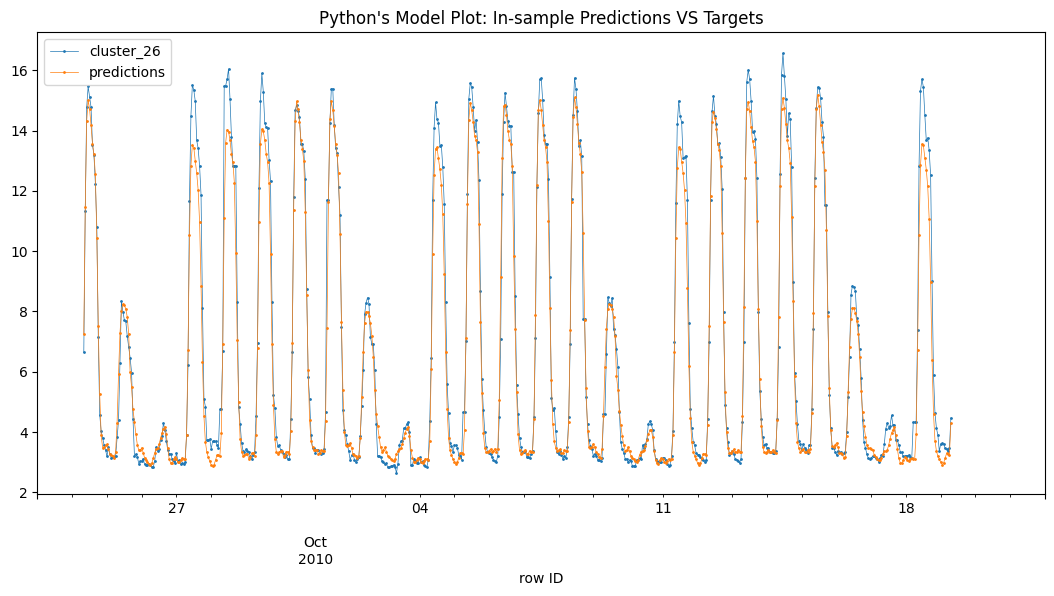

In [45]:
pred_df.plot(
    figsize=(13, 6),
    marker='o',
    markersize=1,
    linewidth=0.5
)
plt.xlim(['2010-09-23', '2010-10-22'])
plt.title("Python's Model Plot: In-sample Predictions VS Targets")
plt.show()

Comparing with KNIME model:

![time_series-result_plot.jpeg](results/time_series-result_plot.jpeg)

In [51]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

sample_test = y_test[:600]
r2 = r2_score(sample_test, y_pred)
mae = mean_absolute_error(sample_test, y_pred)
mse = mean_squared_error(sample_test, y_pred)
rmse = mean_squared_error(sample_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(sample_test, y_pred)

print("Model trained in Python:")
print("--" * 19)
print(f"R2:\t\t\t\t{r2:.3f}")
print(f"Mean absolute error:\t\t{mae:.3f}")
print(f"Mean squared error:\t\t{mse:.3f}")
print(f"Root mean squared error:\t{rmse:.3f}")
print(f"Mean absolute percentage error:\t{mape:.3f}")

Model trained in Python:
--------------------------------------
R2:				0.971
Mean absolute error:		0.486
Mean squared error:		0.582
Root mean squared error:	0.763
Mean absolute percentage error:	0.073


KNIME's model result:

![time_series-statiscal_result.jpeg](results/time_series-statiscal_result.jpeg)

The model trained in Python has different evaluation result every time I tried to train the model, the performance is sometimes better and sometimes worse than the KNIME's model result. This is most likely due to the problem with random initialization of neural network.